G27
Dave Brunner

### Model

A Model here consists of a succession of layers.

Each layer is implemented as a class with the following API-methods:

`forward(torch.tensor)`: Computes the forward pass through the layer, i.e. $x\rightarrow a$<br> and keeps the information needed for computing the backward pass as member variables. 
`backward(torch.tensor)`: Computes the backward pass through the layer in form of the derivatives, i.e. $da \rightarrow dx$. On the fly, it also computes the derivatives w.r.t. the parameters of the layer and keeps them as member variables. It assumes that `forward` method has been run before. <br>
`update(lr)`: Updates the parameters of the layer in accordance with vanilla gradient descent and scalar learning rate `lr`. It assumes that the `forward` and the `backward`-pass has been run before.  

The tensors defined as inputs to the `forward`/`backward`-method are two dimensional with the sample index in the first and the the feature index in the second dimension. 

For fully connected layers with activation function $s(\cdot)$ the formulas are given as follows:

__Forward path:__

$X_{i,j}$: Tensor with shape $(n_b,n_x)$ where $n_b$ is the number of samples in the batch and $n_x$ the number of input features (for MNIST: 784).

$Z_{i,j} = \sum_k X_{i,k} W_{j,k} \qquad (Z = X \cdot W^T + b)$ $\qquad$ ($W$ a tensor of shape $(n_h,n_x)$)

$A_{i,j} = s(Z_{i,j}) \qquad\qquad (A = s(Z))$

__Backward path:__ (with $n_b$ the number of samples in a batch)

$dx_{i,k} = \frac{\partial L}{\partial x_{i,k}} = \sum_j \frac{\partial L}{\partial a_{i,j}} \frac{\partial a_{i,j}}{\partial x_{i,k}} = \sum_j da_{i,j} s^\prime(z_{i,j})\cdot \frac{\partial z_{i,j}}{\partial x_{i,k}} = \sum_j da_{i,j} s^\prime(z_{i,j}) W_{j,k}$<br>

$dW_{j,k} = \frac{\partial L}{\partial W_{j,k}} = \frac{1}{n_b}\sum_{i,l} dA_{i,l}\frac{\partial A_{i,l}}{\partial W_{j,k}} = \frac{1}{n_b}\sum_{i,l} dA_{i,l} s^\prime(Z_{i,l}) \delta_{j,l} X_{i,k} = \frac{1}{n_b}\sum_{i} dA_{i,j} s^\prime(Z_{i,j}) X_{i,k} $<br>






__Parameter Initialisation__ 

The parameters need to be initialised which will be a topic later in the course. For now use the following rules: 
* weights normally distributed with mean $0$ and stdev $1/\sqrt{n_h}$
* bias initialized with zero values

#### <span style="color:red">Important Note on the Implementation</span>

Make sure that all the tensors used anywhere in the model components below have `requires_grad=False`.
Autograd functionality is not allowed for computing the gradients. - Autograd will be used below for testing whether your implementation is correct.

In [11]:
import math
import numpy as np
import torch
import torchvision

### Linear Layer

In [12]:
class LinearLayer():
    def __init__(self, nx, nh):
        """
        nx -- number of input features, i.e. shape of input tensors x given by (*,nb_input)
        nh -- number of output features, i.e. shape of output tensor z given by (*,nb_hidden)
        dw -- represents the gradient of the loss function with respect to the weights w
        db -- represents the gradient of the loss function with respect to the bias b
        """
        self.nx = nx
        self.nh = nh
        self.w = torch.empty(nh, nx).normal_(0, 1. / math.sqrt(self.nh))
        self.b = torch.zeros(nh)
        self.dw = torch.zeros_like(self.w)
        self.db = torch.zeros_like(self.b)
        self.x = None
        self.dx = None

    def forward(self, x):
        """
        Computes the forward pass through the layer
        x -- input tensor
        returns z 
        """
        self.x = x
        return self.x.matmul(self.w.t()) + self.b

    def backward(self, dz):
        """
        Computes the backward pass through the layer incl. the derivatives w.r.t. input x (dx), weight w (dw) and bias b (db).
        dz -- tensor with the backprop'd error signal with the same shape as z.         
        returns dx
        """
        assert len(dz.shape) == 2 and dz.shape[1] == self.nh
        # Compute the gradient with respect to input x (dx)
        self.dx = dz.matmul(self.w)
        # Compute the gradient with respect to weight w (dw)
        self.dw = dz.t().matmul(self.x)
        # Compute the gradient with respect to bias b (db)
        self.db = torch.mean(dz, dim=0)

        # self.db = dz.mean(dim=0)

        # Compute gradient w.r.t. weights
        # self.dw = torch.matmul(dz.t(), self.x) / self.x.shape[0]
        # Compute gradient w.r.t. bias
        # self.db = torch.mean(dz, dim=0)
        return self.dx

    def update(self, lr):
        """
        Updates the parameters of the model (weights w and bias b) with the gradient w.r.t. w and b and learning rate.
        returns None
        """
        self.w -= lr * self.dw
        self.b -= lr * self.db

<span style="color:blue">SHAPE TEST:</span>

In [13]:
linear = LinearLayer(3, 4)
assert (4, 3) == linear.w.shape
assert (4,) == linear.b.shape

x = torch.tensor([[1., 2, 3], [4, 5, 6]])
a = linear.forward(x)
assert (2, 4) == a.shape

dz = torch.tensor([[1., 1, 1, 1], [2., 2, 2, 2]])
dx = linear.backward(dz)
assert (2, 3) == dx.shape
assert (4, 3) == linear.dw.shape

### Activation Function

__Sigmoid__

In [14]:
class SigmoidActivation():

    def __init__(self):
        self.z = None

    def forward(self, z):
        self.z = z
        return 1 / (1 + torch.exp(-z))

    def backward(self, da):
        return da * self.forward(self.z) * (1 - self.forward(self.z))

    def update(self, lr):
        # no update needed for activation function
        pass

### Model

Now implement an MLP as a succession of layers - linear layers and non-linear activation layers.
For creating an instance, you will pass the following arguments: 
* nx: number of input features
* nunits: list of number of units in the hidden layers including the output layer

Add a list of layers as member variable.

Use just a linear layer at the end. Further below we will use a CE loss which is based on the finally output logit values (see lecture of week 2) where the softmax probabilities are implicit.

In [15]:
class MLP():

    def __init__(self, nx, nunits):
        self.nx = nx
        self.nlayers = len(nunits)
        self.nunits = nunits
        self.nunits.insert(0, nx)
        self.nclasses = self.nunits[-1]
        self.layers = []

        for i in range(self.nlayers):
            self.layers.append(LinearLayer(self.nunits[i], self.nunits[i + 1]))
            if i < self.nlayers - 1:
                self.layers.append(SigmoidActivation())

    def forward(self, x):
        """
        x - input tensor        
        returns output tensor of the model
        """
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, dy):
        """
        dy - derivative w.r.t. output tensor
        
        returns derivative with respect to the input tensor of the model; 
        on the fly compute all the derivatives w.r.t. parameters of the model
        """
        for layer in reversed(self.layers):
            dy = layer.backward(dy)
        return dy

    def update(self, lr):
        """
        Update the parameters with the given (stored) derivatives w.r.t. model parameters by using the given learning rate. 
        """
        for layer in self.layers:
            layer.update(lr)


<span style="color:blue">SHAPE TEST:</span>

In [16]:
nx = 2
nunits = [3, 4]
mlp = MLP(nx, nunits)
assert 3 == len(mlp.layers)

x = torch.tensor([[1., 2], [3, 4]])
print(x.shape)
a = mlp.forward(x)
print(f'a: {a.shape}')
assert (2, 4) == a.shape

da = torch.tensor([[1., 1, 1, 1], [2., 2, 2, 2]])
dx = mlp.backward(da)
assert (2, 2) == dx.shape

nx = 2
nunits = [3, 4]
mlp = MLP(nx, nunits)
assert 3 == len(mlp.layers)

x = torch.tensor([[1., 2], [3, 4]])
a = mlp.forward(x)
assert (2, 4) == a.shape

da = torch.tensor([[1., 1, 1, 1], [2., 2, 2, 2]])
dx = mlp.backward(da)
assert (2, 2) == dx.shape

torch.Size([2, 2])
a: torch.Size([2, 4])


### Regression Test

Create a regression testing that allows you to test your implementation by regressing against the gradients computed by pytorch's autograd.

Below you find two functions that may be helpful in 
1. creating a reference model from the given model - makes sure that in the reference model the exact same initialized parameters are used; furthermore, that teh parameters of the linear layers (w,b) are specified as tensors with `requires_grad=True`. 
2. comparing the derivatives w.r.t. parameters for model and refmodel. It assumes that for both, model and refmodel, backprop has been executed. For the model, it means that `backward()`has been executed - for the ref model, only `forward` has been executed, but `backward` applied to the output tensor of the refmodel. For the remodel, we use `grad` of the weights and bias tensors, for the model the parameters `dw` and `db` as basis for the comparison.

<span style="color:red">Adjust these methods to make them compliant with your model - it uses internals of our implementation.</span>

In [17]:
def create_refmodel(model):
    refmodel = MLP(model.nx, model.nunits[1:])
    for i, layer in enumerate(model.layers):
        if isinstance(layer, LinearLayer):
            refmodel.layers[i].w = model.layers[i].w.detach().clone()
            refmodel.layers[i].w.requires_grad_()
            refmodel.layers[i].b = model.layers[i].b.detach().clone()
            refmodel.layers[i].b.requires_grad_()
    return refmodel


def test_params(model, refmodel, digits=8):
    for i, layer in enumerate(model.layers):
        if isinstance(layer, LinearLayer):
            try:
                xxref = refmodel.layers[i].w.grad.detach().numpy()
                xx = model.layers[i].dw.numpy()
                np.testing.assert_array_almost_equal(xx, xxref, decimal=digits, err_msg="Error: layer %i" % i)
                xxref = refmodel.layers[i].b.grad.detach().numpy()
                xx = model.layers[i].db.numpy()
                np.testing.assert_array_almost_equal(xx, xxref, decimal=digits, err_msg="Error: layer %i" % i)

            except Exception as e:
                print("test failed - reason:", e)


<span style="color:blue"> REGRESSION TEST</span>

In [18]:
# inputs
nx = 10
x = torch.randn(nx).reshape(-1, nx)

# model instance
nunits = [20, 40, 1]
mlp = MLP(nx, nunits)

# forward and backward pass
z = mlp.forward(x)
dz = torch.tensor([1., ]).reshape(-1, 1)
dx = mlp.backward(dz)

# create ref model
mlpref = create_refmodel(mlp)

# only use the forward method of the ref model - and apply backward to the output tensor.
zref = mlpref.forward(x)
zref.backward()

# compare the derivatives computed by your model with the grad computed by pytorch's autograd
test_params(mlp, mlpref, digits=7)

### Cost 

Use the cross-entropy cost function directly defined on the basis of the logits - which implicitly includes a softmax calculation (see lecture notes of week 2).

In [19]:
class CELoss:
    def __init__(self):
        pass

    def value(self, z, y):
        """
        Calculate the cross-entropy loss given predicted logits z and true labels y.
        
        Args:
        - z (torch.Tensor): Predicted logits of shape (number of samples, number of classes).
        - y (torch.Tensor): True labels of shape (number of samples).
        
        Returns:
        - loss (torch.Tensor): Cross-entropy loss.
        """
        probabilities = torch.nn.functional.softmax(z, dim=1)

        # Gather probabilities corresponding to true class labels
        true_probabilities = torch.gather(probabilities, 1, y.view(-1, 1)).squeeze()

        # Compute negative log probabilities of true class labels
        neg_log_probs = -torch.log(true_probabilities)

        # Compute total cross-entropy loss over all samples
        loss = torch.sum(neg_log_probs)
        return loss

    def derivative(self, z, y):
        """
        Calculate the derivative of cross-entropy loss with respect to predicted logits z.
        
        Args:
        - z (torch.Tensor): Predicted logits of shape (number of samples, number of classes).
        - y (torch.Tensor): True labels of shape (number of samples).
        
        Returns:
        - derivative (torch.Tensor): Derivative of cross-entropy loss with respect to z.
        """
        # Compute softmax probabilities
        softmax_z = torch.softmax(z, dim=1)

        # Create one-hot encoded labels
        one_hot_y = torch.zeros_like(z)
        one_hot_y[torch.arange(z.size(0)), y] = 1

        # Calculate derivative of cross-entropy loss
        derivative = softmax_z - one_hot_y

        return derivative


In [20]:
loss = CELoss()
ypred = torch.log(torch.tensor([[0.5, 0.4, 0.1], [0.2, 0.1, 0.7]])).reshape(-1, 3)  # -> logits z
y = torch.tensor([1, 2]).reshape(-1)
np.testing.assert_almost_equal(loss.value(ypred, y), -torch.log(torch.tensor([0.4, 0.7])).sum(), decimal=8)
np.testing.assert_array_almost_equal(loss.derivative(ypred, y),
                                     torch.tensor([[0.5000, -0.6000, 0.1000], [0.2000, 0.1000, -0.3000]]), decimal=8)

### Load Data

As in previous' week PW. 

In [21]:
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [22]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

### Training Loop

Implement mini-batch gradient descent training loop. 

With the implementation of the two methods below you will be able to train and test the MLP:
* train_epoch: for training the model over one epoch with per mini-batch updates
* test_epoch: for evaluating the test/validation performance per epoch.

In [23]:
def train_epoch(model, loss, dataloader, lr):
    """
    Iterate over the mini-batches of one epoch, compute per mini-batch the forward and backward pass 
    and update the parameters. Also compute the loss and accuracy as an average over the epoch. 
    Note that this average includes per mini-batch updated model predictions and parameter updates.
    model -- model to be trained
    loss -- loss function to be used 
    dataloader -- data loader that provides mini-batches (from the training set)
    lr -- learning rate to be used in the parameter updates     
    returns loss, accuracy 
    """
    ### YOUR CODE START ###
    nsamples = len(dataloader.dataset)
    trainloss, correct = 0.0, 0
    for X, y in dataloader:
        batchsize = X.shape[0]
        X = X.view(batchsize, -1)
        z = model.forward(X)
        batchloss = loss.value(z, y)
        trainloss += batchloss.item()
        correct += (z.argmax(dim=1) == y).type(torch.float).sum().item()

        # Backpropagation
        dz = loss.derivative(z, y)
        dx = model.backward(dz)
        model.update(lr)
    trainloss /= nsamples
    correct /= nsamples
    return trainloss, correct
    ### YOUR CODE START ###


def test_epoch(model, loss, dataloader):
    """
    Iterate over the mini-batches of one epoch of the test set. Iterates over the mini-batches of the test set.
    Estimates loss and accuracy as an average over the test (validation) set. The model is not updates here. 
    model -- model to be evaluated
    loss -- loss function to be evaluated 
    dataloader -- data loader that provides mini-batches (from the test/validation set)
    returns loss, accuracy 
    """
    nsamples = len(dataloader.dataset)
    testloss, correct = 0.0, 0
    for X, y in dataloader:
        batchsize = X.shape[0]
        X = X.view(batchsize, -1)
        z = model.forward(X)
        testloss += loss.value(z, y)
        correct += (z.argmax(dim=1) == y).type(torch.float).sum().item()

    testloss /= nsamples
    correct /= nsamples
    return testloss, correct


### First Simple Check: Overfitting on Single Sample

Load an arbitrary mini-batch from the training set. Train the model by using just this mini-batch.
This is another test for checking whether your implementation is capable of learning something (see remark in week 2 of the course).

In [24]:
sample_batch, _ = torch.utils.data.random_split(train_data, [64, 60000 - 64])
train_loader = DataLoader(sample_batch, batch_size=64,
                          shuffle=False)  # shuffling not needed since only one batch is used.

sample_x, sample_y = next(iter(train_loader))
print(sample_x.shape, sample_y.shape)

torch.Size([64, 1, 28, 28]) torch.Size([64])


In [25]:
epochs = 100
lr = 0.1
mlp = MLP(28 * 28, [100, 10])
mseloss = CELoss()
trainlosses = []
trainaccs = []
for t in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    trainlosses.append(trainloss)
    trainaccs.append(trainacc)
    if t % 10 == 0:
        print(f"Epoch: {t}, Train Accuracy: {(100 * trainacc):>0.1f}%, Train Loss: {trainloss:>8f}")

Epoch: 0, Train Accuracy: 10.9%, Train Loss: 3.621738
Epoch: 10, Train Accuracy: 10.9%, Train Loss: 11.560341
Epoch: 20, Train Accuracy: 20.3%, Train Loss: 4.013179
Epoch: 30, Train Accuracy: 29.7%, Train Loss: 4.969628
Epoch: 40, Train Accuracy: 60.9%, Train Loss: 1.437512
Epoch: 50, Train Accuracy: 84.4%, Train Loss: 0.532017
Epoch: 60, Train Accuracy: 54.7%, Train Loss: 1.671467
Epoch: 70, Train Accuracy: 93.8%, Train Loss: 0.200899
Epoch: 80, Train Accuracy: 96.9%, Train Loss: 0.114815
Epoch: 90, Train Accuracy: 96.9%, Train Loss: 0.098066


Text(0.5, 1.0, 'Train Accuracy')

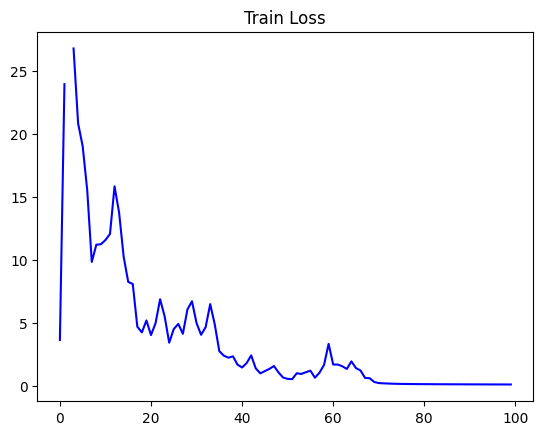

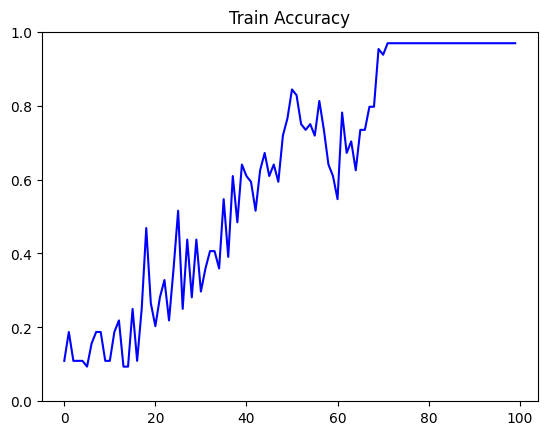

In [26]:
plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses, "b-")
plt.title("Train Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs, "b-")
plt.ylim([0.0, 1])
plt.title("Train Accuracy")

### Training with all the training set

In [27]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

In [28]:
epochs = 10
lr = 0.1
mlp = MLP(28 * 28, [100, 10])
mseloss = CELoss()
trainlosses, testlosses = [], []
trainaccs, testaccs = [], []

for epoch in range(epochs):
    trainloss, trainacc = train_epoch(mlp, mseloss, train_loader, lr)
    testloss, testacc = test_epoch(mlp, mseloss, test_loader)
    trainlosses.append(trainloss)
    testlosses.append(testloss)
    trainaccs.append(trainacc)
    testaccs.append(testacc)
    print(
        f"Epoch: {epoch}, Train Accuracy: {(100 * trainacc):>0.1f}%, Train Loss: {trainloss:>8f}, Test Accuracy: {(100 * testacc):>0.1f}%, Test Loss: {testloss:>8f}")

Epoch: 0, Train Accuracy: 86.6%, Train Loss:      inf, Test Accuracy: 93.4%, Test Loss: 0.232688
Epoch: 1, Train Accuracy: 94.1%, Train Loss: 0.204670, Test Accuracy: 94.2%, Test Loss: 0.193271
Epoch: 2, Train Accuracy: 95.1%, Train Loss: 0.166245, Test Accuracy: 95.1%, Test Loss: 0.177834
Epoch: 3, Train Accuracy: 95.7%, Train Loss: 0.145926, Test Accuracy: 94.5%, Test Loss: 0.182599
Epoch: 4, Train Accuracy: 95.9%, Train Loss: 0.134223, Test Accuracy: 95.1%, Test Loss: 0.171103
Epoch: 5, Train Accuracy: 96.3%, Train Loss: 0.122361, Test Accuracy: 96.0%, Test Loss: 0.138013
Epoch: 6, Train Accuracy: 96.7%, Train Loss: 0.110377, Test Accuracy: 95.6%, Test Loss: 0.148059
Epoch: 7, Train Accuracy: 97.0%, Train Loss: 0.100720, Test Accuracy: 96.1%, Test Loss: 0.137996
Epoch: 8, Train Accuracy: 97.0%, Train Loss: 0.095927, Test Accuracy: 96.3%, Test Loss: 0.129696
Epoch: 9, Train Accuracy: 97.3%, Train Loss: 0.086366, Test Accuracy: 96.2%, Test Loss: 0.136981


Text(0.5, 1.0, 'Accuracy')

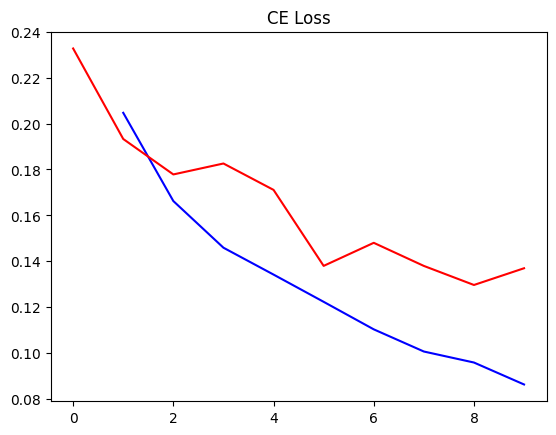

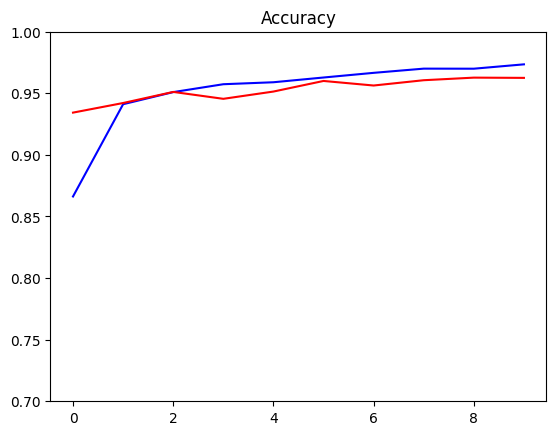

In [29]:
plt.figure(1)
plt.plot(torch.arange(epochs), trainlosses, "b-")
plt.plot(torch.arange(epochs), testlosses, "r-")
plt.title("CE Loss")

plt.figure(2)
plt.plot(torch.arange(epochs), trainaccs, "b-")
plt.plot(torch.arange(epochs), testaccs, "r-")
plt.ylim([0.7, 1])
plt.title("Accuracy")
